# Machine Learning Group Project - Group 50
## Masters in Data Science and Advanced Analytics at NOVA IMS, Lisbon

## Group Information
Group members: **<span style="color:red">(Everyone please check and correct the names)</span><br>**
Md. Shawkatul Islam Aziz<br>
Md. Tahir Hossain<br>
Philipp Metzger<br>
Ali Sabbir<br>
Henrique Vaz<br>

## Import all libraries needed

In [1]:
import os
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load the data

In [2]:
train = pd.read_excel(os.path.join('Data', 'Train.xlsx'), sheet_name='Sheet1')
test = pd.read_excel(os.path.join('Data', 'Test.xlsx'), sheet_name='Sheet1')

## First exploration of the training set

In [3]:
# Show the first three rows of 'train'
train.head(3)

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1


In [4]:
# Get the dimensions of 'train'
train.shape

(22400, 15)

In [5]:
# Check the data types and check if there are missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              22400 non-null  int64 
 1   Name                    22400 non-null  object
 2   Birthday                22400 non-null  object
 3   Native Continent        22400 non-null  object
 4   Marital Status          22400 non-null  object
 5   Lives with              22400 non-null  object
 6   Base Area               22400 non-null  object
 7   Education Level         22400 non-null  object
 8   Years of Education      22400 non-null  int64 
 9   Employment Sector       22400 non-null  object
 10  Role                    22400 non-null  object
 11  Working Hours per week  22400 non-null  int64 
 12  Money Received          22400 non-null  int64 
 13  Ticket Price            22400 non-null  int64 
 14  Income                  22400 non-null  int64 
dtypes:

In [6]:
# Get the basic descriptive statistics on 'train'
train.describe()

,CITIZEN_ID,Years of Education,Working Hours per week,Money Received,Ticket Price,Income
count,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000
mean,23685.500000,13.173884,40.483795,1324.915357,109.145313,0.237098
std,6466.467351,2.512451,12.370921,9227.771813,500.208904,0.425313
min,12486.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,18085.750000,12.000000,40.000000,0.000000,0.000000,0.000000
50%,23685.500000,13.000000,40.000000,0.000000,0.000000,0.000000
75%,29285.250000,15.000000,45.000000,0.000000,0.000000,0.000000
max,34885.000000,21.000000,99.000000,122999.000000,5358.000000,1.000000


## Transform 'Birthday' to datetime format and get the age in days relative to today

In [7]:
# Define a function that maps month names to their integers

def monthToInt(monthStr):

    return {
            'January' : 1,
            'February' : 2,
            'March' : 3,
            'April' : 4,
            'May' : 5,
            'June' : 6,
            'July' : 7,
            'August' : 8,
            'September' : 9, 
            'October' : 10,
            'November' : 11,
            'December' : 12
    }[monthStr]

In [8]:
# Define a function that checks if a year is a leap year
# Adapted from:
# https://www.programiz.com/python-programming/examples/leap-year

# "A leap year is exactly divisible by 4 except for century years (years ending with 00). 
# The century year is a leap year only if it is perfectly divisible by 400."

def is_leapyear(year):
    if (year % 4) == 0:
        if (year % 100) == 0:
            if (year % 400) == 0:
                return True
            else:
                return False
        else:
            return True
    else:
        return False

In [9]:
# Define a function that takes uses the information from column 'Birthday' and adds a column that contains the
# birthdays as datetime objects and another column that contains the age of the person in days relative to today (2020)

def add_Birthday_date_Age_days_rel_to_2020(df):
    
    # Make a copy
    df_copy = df.copy()
    
    # Get the year, month and day from Strings in 'Birthday'
    split = df_copy.Birthday.str.split(',', expand=True)
    year = split.iloc[:,1].astype(int)
    month_day = split.iloc[:,0].str.strip(to_strip=' ').str.split(' ', expand=True)
    day = month_day.iloc[:,1].astype(int)
    month = month_day.iloc[:,0]
    
    # Map month names to integers
    month = month.map(lambda x:monthToInt(x))
    
    # Build a dataframe containing the date values
    frame = {'year':year, 'month':month, 'day':day}
    birthday = pd.DataFrame(frame)
    
    # Create datetime objects from the date values
    # Some problems with leap years (see below)
    birthday_date = []
    for i in range(birthday.shape[0]):
    
        # Get the values for this row
        year_i = int(birthday.iloc[i,0])
        month_i = int(birthday.iloc[i,1])
        day_i = int(birthday.iloc[i,2])

        # Leap years are incorrectly defined for this dataset.
        # For example row 359: year 2022, month 2, day 29 is a birthday in this datase, but in reality it does not exist.
        # -> Decrease all days where month=2 and day=29 that aren't in a leap year by 1 day to be able to use 
        # datetime.date

        # Get True if this year is a leap year, else False
        leapyear = is_leapyear(year_i)

        if (~leapyear and month_i==2 and day_i==29):
            day_i = day_i - 1
        date = datetime.date(year_i, month_i, day_i)
        birthday_date.append(date)
        
    # Convert the list to a pandas series
    birthday_date = pd.Series(birthday_date)
    
    # Insert 'birthday_date' as new column 'Birthday_date'
    df_copy.insert(loc=3, column='Birthday_date', value=birthday_date)
    
    # Compute time differences to today (2020) and keep only the value in days
    now = date.today()
    age = now - df_copy.Birthday_date
    age_days = age.dt.days
    
    # Insert 'age_days' as 'Age_days_rel_to_2020'
    df_copy.insert(loc=4, column='Age_days_rel_to_2020', value=age_days)
    
    # Return the resulting dataframe
    return df_copy

In [10]:
# Use the function defined above to add columns 'Birthday_date' and 'Age_days_rel_to_2020' to 'train'
train_2 = add_Birthday_date_Age_days_rel_to_2020(train)

In [11]:
# Drop columns 'Birthday' and 'Birthday_date'
train_2 = train_2.drop(columns=['Birthday', 'Birthday_date'])

In [12]:
# Check the result
train_2.head(3)

,CITIZEN_ID,Name,Age_days_rel_to_2020,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,6354,Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,5415,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,4214,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1


## Compute and visualise the correlations between the metric features and the target

In [13]:
# Define metric features and target in one list
metric_features_and_target = ['Age_days_rel_to_2020','Years of Education','Working Hours per week','Money Received','Ticket Price','Income']

In [14]:
# Compute the correlation matrix of 'train'
corr_pearson = train_2[metric_features_and_target].corr(method='pearson')
corr_spearman = train_2[metric_features_and_target].corr(method='spearman')

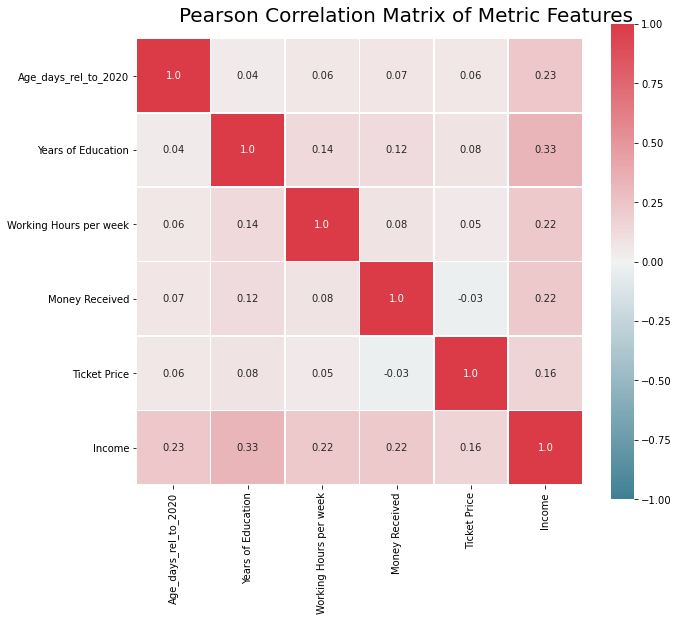

In [15]:
# Adapted from data mining lab 4:

# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Round the values of the correlation matrix
corr_rounded = np.round(corr_pearson, decimals=2)

# Build annotation matrix (values above |limit| will appear annotated in the plot)
limit=0.001
mask_annot = np.absolute(corr_rounded.values) >= limit
annot = np.where(mask_annot, corr_rounded.values, np.full(corr_rounded.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr_rounded, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix of Metric Features", fontsize=20)

plt.show()

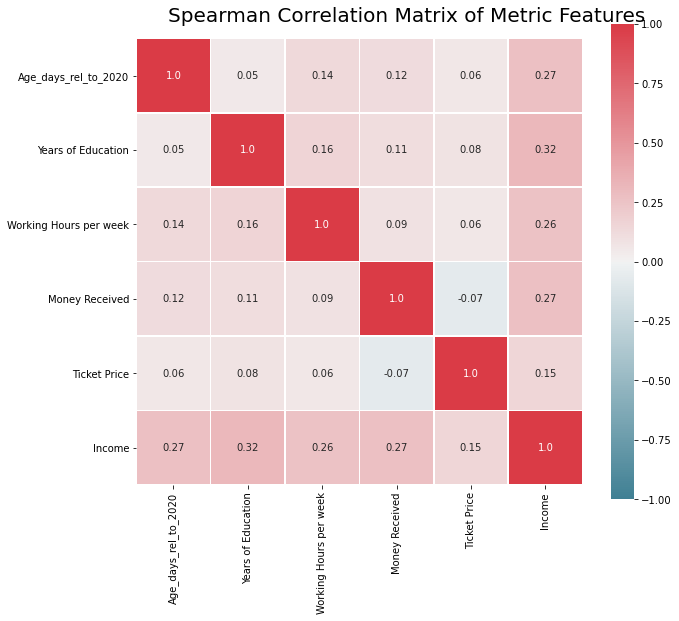

In [16]:
# Adapted from data mining lab 4:

# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Round the values of the correlation matrix
corr_rounded = np.round(corr_spearman, decimals=2)

# Build annotation matrix (values above |limit| will appear annotated in the plot)
limit=0.001
mask_annot = np.absolute(corr_rounded.values) >= limit
annot = np.where(mask_annot, corr_rounded.values, np.full(corr_rounded.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr_rounded, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Spearman Correlation Matrix of Metric Features", fontsize=20)

plt.show()

## One-hot encode categorical features
### One-hot encode 'Native Continent'

In [102]:
# Define a function that replaces a column by a set of columns
def replace_col(df, col_name, new_cols):
    df_copy = df.copy()
    col_index = df_copy.columns.get_loc(col_name)
    df_copy = df_copy.drop(columns=col_name)
    for col in range(new_cols.shape[1]):
        df_copy.insert(loc=col_index+col, column=list(new_cols)[col], value=new_cols.iloc[:,col])
    return df_copy    

In [103]:
# Define a function that one-hot encodes a column
def one_hot_encode(df, col_name, prefix):
    
    df_copy = df.copy()
    
    # Print the unique values to be one-hot encoded
    print('Unique values to be one-hot encoded:')
    print(pd.unique(df_copy[col_name]))
    
    # Compute dummy matrix
    y = pd.get_dummies(df_copy[col_name], prefix=prefix, dtype=float)
    
    if False:
        # Keeping all five variables would lead to one column being explained by the other 4 columns. Show this:
        a=y.iloc[:,0]+y.iloc[:,1]+y.iloc[:,2]+y.iloc[:,3]
        b=y.iloc[:,4]
        print()
        print('Correlation matrix of the dummy features matrix:')
        print(np.corrcoef(a.values,b.values))
    
    # Discard the last dummy column 
    y = y.drop(list(y)[y.shape[1]-1], axis=1)
    
    # Print the column that was discarded
    print()
    print('Column dropped (Case for which all dummy values = 0):')
    print(list(y)[y.shape[1]-1])
    
    # Use 'replace_col'
    df_copy = replace_col(df_copy, col_name, y)
    
    # Return the result
    return df_copy

In [104]:
# Use 'one_hot_encode' on 'Native Continent'
train_3 = one_hot_encode(train_2, 'Native Continent', 'Continent')

Unique values to be one-hot encoded:
['Europe' 'Africa' 'Asia' 'America' 'Oceania']

Column dropped (Case for which all dummy values = 0):
Continent_Europe


In [105]:
# Print the column labels of the resulting dataframe
list(train_3)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Continent_Africa',
 'Continent_America',
 'Continent_Asia',
 'Continent_Europe',
 'Marital Status',
 'Lives with',
 'Base Area',
 'Education Level',
 'Years of Education',
 'Employment Sector',
 'Role',
 'Working Hours per week',
 'Money Received',
 'Ticket Price',
 'Income']

In [106]:
# Use 'one_hot_encode' on 'Native Continent'
train_4 = one_hot_encode(train_3, 'Marital Status', 'Marital_Status')

Unique values to be one-hot encoded:
['Married' 'Single' 'Married - Spouse Missing' 'Divorced' 'Separated'
 'Widow' 'Married - Spouse in the Army']

Column dropped (Case for which all dummy values = 0):
Marital_Status_Single


In [107]:
# Print the column labels of the resulting dataframe
list(train_4)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Continent_Africa',
 'Continent_America',
 'Continent_Asia',
 'Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives with',
 'Base Area',
 'Education Level',
 'Years of Education',
 'Employment Sector',
 'Role',
 'Working Hours per week',
 'Money Received',
 'Ticket Price',
 'Income']

In [108]:
# Use 'one_hot_encode' on 'Lives with'
train_5 = one_hot_encode(train_4, 'Lives with', 'Lives_with')

Unique values to be one-hot encoded:
['Wife' 'Other Family' 'Children' 'Other relatives' 'Alone' 'Husband']

Column dropped (Case for which all dummy values = 0):
Lives_with_Other relatives


In [109]:
# Print the column labels of the resulting dataframe
list(train_5)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Continent_Africa',
 'Continent_America',
 'Continent_Asia',
 'Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives_with_Alone',
 'Lives_with_Children',
 'Lives_with_Husband',
 'Lives_with_Other Family',
 'Lives_with_Other relatives',
 'Base Area',
 'Education Level',
 'Years of Education',
 'Employment Sector',
 'Role',
 'Working Hours per week',
 'Money Received',
 'Ticket Price',
 'Income']

In [110]:
# Use 'one_hot_encode' on 'Base Area'
train_6 = one_hot_encode(train_5, 'Base Area', 'Base_Area')

Unique values to be one-hot encoded:
['Northbury' 'Auchenshuggle' 'Sharnwick' 'Laewaes' 'MillerVille' '?'
 'Fanfoss' 'Wigston' "Knife's Edge" 'Aerilon' 'Watford' 'Lanercost'
 'Bellmoral' 'Marnmouth' 'Bellenau' 'Butterpond' 'Laenteglos' 'Tranmere'
 'Eelry' 'Alverton' 'Pran' 'Willesden' "King's Watch" 'Kald' 'Kirkwall'
 "Fool's March" 'Middlesbrough' 'Orilon' 'Aroonshire' 'Aberuthven'
 'Sharpton' 'Lewes' 'Mensfield' 'Cherrytown' 'Redwick Bush' 'Drumchapel'
 'Carlisle' 'Conriston' 'Woodpine' 'Ironforge']

Column dropped (Case for which all dummy values = 0):
Base_Area_Willesden


In [111]:
# Print the column labels of the resulting dataframe
list(train_6)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Continent_Africa',
 'Continent_America',
 'Continent_Asia',
 'Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives_with_Alone',
 'Lives_with_Children',
 'Lives_with_Husband',
 'Lives_with_Other Family',
 'Lives_with_Other relatives',
 'Base_Area_?',
 'Base_Area_Aberuthven',
 'Base_Area_Aerilon',
 'Base_Area_Alverton',
 'Base_Area_Aroonshire',
 'Base_Area_Auchenshuggle',
 'Base_Area_Bellenau',
 'Base_Area_Bellmoral',
 'Base_Area_Butterpond',
 'Base_Area_Carlisle',
 'Base_Area_Cherrytown',
 'Base_Area_Conriston',
 'Base_Area_Drumchapel',
 'Base_Area_Eelry',
 'Base_Area_Fanfoss',
 "Base_Area_Fool's March",
 'Base_Area_Ironforge',
 'Base_Area_Kald',
 "Base_Area_King's Watch",
 'Base_Area_Kirkwall',
 "Base_Area_Knife's Edge",
 'Base_Area_Laenteglos',
 'Base_Area_Laewa

In [112]:
# Use 'one_hot_encode' on 'Base Area'
train_7 = one_hot_encode(train_6, 'Education Level', 'Education_Level')

Unique values to be one-hot encoded:
['High School + PostGraduation' 'Professional School'
 'High School - 2nd Cycle' 'PhD' 'Bachelors' 'Bachelors + PostGraduation'
 'Masters' 'High School - 1st Cycle' 'High School Complete'
 'Masters + PostGraduation' 'Professional School + PostGraduation'
 'Middle School - 2nd Cycle' 'Middle School Complete'
 'Middle School - 1st Cycle' 'Primary School' 'Preschool']

Column dropped (Case for which all dummy values = 0):
Education_Level_Professional School


In [113]:
# Print the column labels of the resulting dataframe
list(train_7)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Continent_Africa',
 'Continent_America',
 'Continent_Asia',
 'Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives_with_Alone',
 'Lives_with_Children',
 'Lives_with_Husband',
 'Lives_with_Other Family',
 'Lives_with_Other relatives',
 'Base_Area_?',
 'Base_Area_Aberuthven',
 'Base_Area_Aerilon',
 'Base_Area_Alverton',
 'Base_Area_Aroonshire',
 'Base_Area_Auchenshuggle',
 'Base_Area_Bellenau',
 'Base_Area_Bellmoral',
 'Base_Area_Butterpond',
 'Base_Area_Carlisle',
 'Base_Area_Cherrytown',
 'Base_Area_Conriston',
 'Base_Area_Drumchapel',
 'Base_Area_Eelry',
 'Base_Area_Fanfoss',
 "Base_Area_Fool's March",
 'Base_Area_Ironforge',
 'Base_Area_Kald',
 "Base_Area_King's Watch",
 'Base_Area_Kirkwall',
 "Base_Area_Knife's Edge",
 'Base_Area_Laenteglos',
 'Base_Area_Laewa

In [114]:
# Use 'one_hot_encode' on 'Base Area'
train_8 = one_hot_encode(train_7, 'Employment Sector', 'Employment_Sector')

Unique values to be one-hot encoded:
['Private Sector - Services ' 'Public Sector - Others'
 'Self-Employed (Individual)' 'Private Sector - Others' '?'
 'Self-Employed (Company)' 'Public Sector - Government' 'Unemployed'
 'Never Worked']

Column dropped (Case for which all dummy values = 0):
Employment_Sector_Self-Employed (Individual)


In [115]:
# Print the column labels of the resulting dataframe
list(train_8)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Continent_Africa',
 'Continent_America',
 'Continent_Asia',
 'Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives_with_Alone',
 'Lives_with_Children',
 'Lives_with_Husband',
 'Lives_with_Other Family',
 'Lives_with_Other relatives',
 'Base_Area_?',
 'Base_Area_Aberuthven',
 'Base_Area_Aerilon',
 'Base_Area_Alverton',
 'Base_Area_Aroonshire',
 'Base_Area_Auchenshuggle',
 'Base_Area_Bellenau',
 'Base_Area_Bellmoral',
 'Base_Area_Butterpond',
 'Base_Area_Carlisle',
 'Base_Area_Cherrytown',
 'Base_Area_Conriston',
 'Base_Area_Drumchapel',
 'Base_Area_Eelry',
 'Base_Area_Fanfoss',
 "Base_Area_Fool's March",
 'Base_Area_Ironforge',
 'Base_Area_Kald',
 "Base_Area_King's Watch",
 'Base_Area_Kirkwall',
 "Base_Area_Knife's Edge",
 'Base_Area_Laenteglos',
 'Base_Area_Laewa

In [116]:
# Use 'one_hot_encode' on 'Base Area'
train_9 = one_hot_encode(train_8, 'Role', 'Role')

Unique values to be one-hot encoded:
['Repair & constructions' 'Sales' 'Security' 'Professor'
 'Cleaners & Handlers' 'Other services' 'Machine Operators & Inspectors'
 'Management' 'Administratives' 'Transports' '?' 'Agriculture and Fishing'
 'IT' 'Household Services' 'Army']

Column dropped (Case for which all dummy values = 0):
Role_Security


In [117]:
# Print the column labels of the resulting dataframe
list(train_9)

['CITIZEN_ID',
 'Name',
 'Age_days_rel_to_2020',
 'Continent_Africa',
 'Continent_America',
 'Continent_Asia',
 'Continent_Europe',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Married - Spouse Missing',
 'Marital_Status_Married - Spouse in the Army',
 'Marital_Status_Separated',
 'Marital_Status_Single',
 'Lives_with_Alone',
 'Lives_with_Children',
 'Lives_with_Husband',
 'Lives_with_Other Family',
 'Lives_with_Other relatives',
 'Base_Area_?',
 'Base_Area_Aberuthven',
 'Base_Area_Aerilon',
 'Base_Area_Alverton',
 'Base_Area_Aroonshire',
 'Base_Area_Auchenshuggle',
 'Base_Area_Bellenau',
 'Base_Area_Bellmoral',
 'Base_Area_Butterpond',
 'Base_Area_Carlisle',
 'Base_Area_Cherrytown',
 'Base_Area_Conriston',
 'Base_Area_Drumchapel',
 'Base_Area_Eelry',
 'Base_Area_Fanfoss',
 "Base_Area_Fool's March",
 'Base_Area_Ironforge',
 'Base_Area_Kald',
 "Base_Area_King's Watch",
 'Base_Area_Kirkwall',
 "Base_Area_Knife's Edge",
 'Base_Area_Laenteglos',
 'Base_Area_Laewa

In [118]:
train_9.head(3)

,CITIZEN_ID,Name,Age_days_rel_to_2020,Continent_Africa,Continent_America,Continent_Asia,Continent_Europe,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Married - Spouse Missing,...,Role_Management,Role_Other services,Role_Professor,Role_Repair & constructions,Role_Sales,Role_Security,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,6354,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,40,0,2273,1
1,12487,Mr. Cameron McDonald,5415,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,40,0,0,1
2,12488,Mr. Keith Davidson,4214,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,46,0,2321,1


In [121]:
train = train_9

## Features Selection

In [124]:
data = train.iloc[:,:-1]
target = train.iloc[:,-1]